### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
import fabio
import pyFAI
from pyFAI.detectors import Pilatus1M
from scipy import optimize
import scipy.constants as con

ModuleNotFoundError: No module named 'fabio'

In [2]:
%matplotlib notebook

### custom colormap

In [3]:
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1.0, 0.7, 0.7))
         }
red_alpha = LinearSegmentedColormap('red_alpha', cdict)
plt.register_cmap(cmap=red_alpha)

### load image with fabio

In [4]:
image_path = 'pilatus_2020kw26_01017.tif'
image_object = fabio.open(image_path)
image = image_object.data
# print(image_object.header)

### plot image

<IPython.core.display.Javascript object>


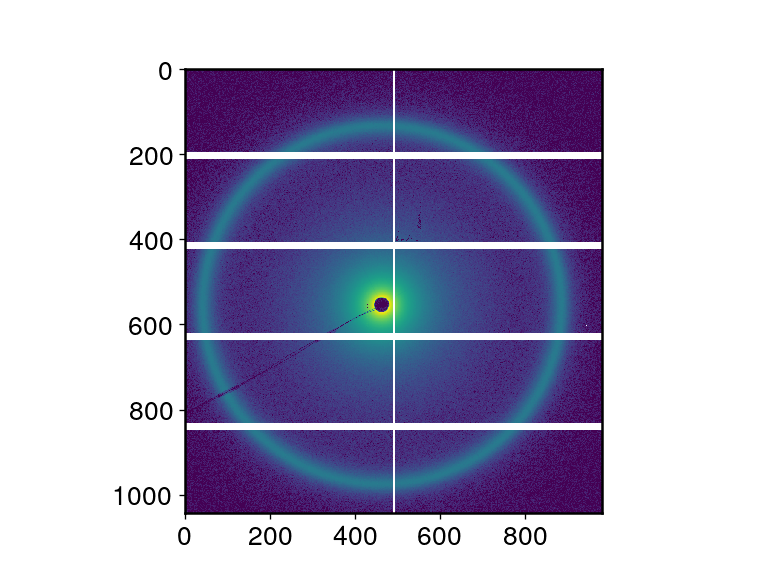

In [5]:
fig, ax = plt.subplots()
ax.imshow(image, norm=LogNorm())

### center determination

In [6]:
# some function needed for that
def gauss_circle(x, y, x0, y0, r, sigma):
    return np.exp(-(np.sqrt((x0 - x)**2+(y0 - y)**2) - r)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

def in_circle(x, y, x0, y0, r):
    return (x - x0)**2 + (y - y0)**2 < r**2

def create_mask(img, *args, ul=1e6, ll=0):
    mask = img < ll
    mask[img > ul] = True
    for arg in args:
        mask[arg] = True
    return mask

In [7]:
# produce a meshgrid with x and y components
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))

In [8]:
# mask the center of the image
mask = ~create_mask(image, in_circle(X, Y, 450, 550, 200))

In [9]:
# fitfunction 
def fun(x):
    x0, y0, r = x
    fun_val = -np.sum(image * gauss_circle(X, Y, x0, y0, r, sigma) * mask)\
    / np.sum(gauss_circle(X, Y, x0, y0, r, sigma) * mask)
    return fun_val

In [10]:
x0 = 450
y0 = 550
radius = 400
sigma = 1

res = optimize.minimize(fun, [x0, y0, radius], method='Nelder-Mead')
res

 final_simplex: (array([[462.079948  , 553.69260671, 421.02720294],
       [462.07998561, 553.69270205, 421.02714192],
       [462.07987546, 553.69266865, 421.02718422],
       [462.07987738, 553.69259489, 421.02715043]]), array([-156.75631934, -156.75631934, -156.75631934, -156.75631934]))
           fun: -156.75631933825315
       message: 'Optimization terminated successfully.'
          nfev: 136
           nit: 72
        status: 0
       success: True
             x: array([462.079948  , 553.69260671, 421.02720294])

<IPython.core.display.Javascript object>


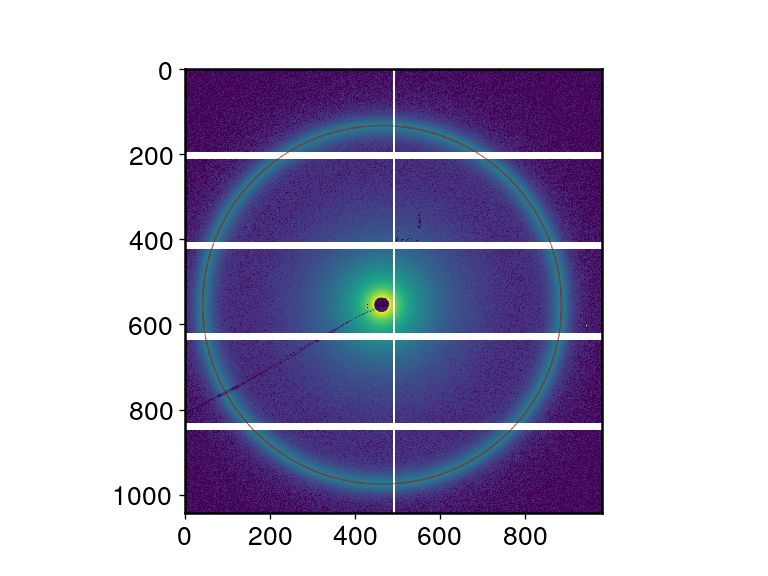

In [11]:
fig, ax = plt.subplots()
ax.imshow(image, norm=LogNorm())
ax.imshow(gauss_circle(X, Y, res['x'][0], res['x'][1], res['x'][2], sigma), cmap='red_alpha')

### calculate distance
$q = \frac{4\pi}{\lambda}\cdot\sin{\theta}$


$\tan{2\theta} = \frac{\mathrm{radius}}{\mathrm{dist}}$


$\mathrm{dist} = \mathrm{radius}\cdot(\tan{2\theta})^{-1} = \mathrm{radius} \cdot (\tan{(2\arcsin{\frac{q \lambda}{4\pi}})})^{-1}$

In [12]:
pixelsize = 172e-6
q_agbh = 1.070057  # nm^-1
wavelength = con.h * con.c / con.e / 8000  # m
theta = np.arcsin(wavelength * 1e9 * q_agbh/ 4 / np.pi)
dist = res['x'][2] * pixelsize / np.tan(2 * theta)  # m
print("sample-detector distance = {} m".format(round(dist, 3)))

sample-detector distance = 2.743 m


### azimuthal integration 1d

In [13]:
# for real data use also mask option of AI class
# notice that poni1 correspond to y and poni2 to x coordinate of detector
# for more information on geometry visit (figure at bottom of page):
# https://pyfai.readthedocs.io/en/latest/usage/tutorial/Geometry/geometry.html

ai = pyFAI.AzimuthalIntegrator(dist=dist, poni1=res['x'][1]*pixelsize, poni2=res['x'][0]*pixelsize,
                               detector=Pilatus1M(), wavelength=wavelength)
ai

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.549802e-10m
SampleDetDist= 2.742974e+00m	PONI= 9.523513e-02, 7.947775e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 2742.974mm	Center: x=462.080, y=553.693 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

In [14]:
# usage of integrate 1d method
q, I, e = ai.integrate1d(image, 800, error_model='poisson')

In [15]:
# for additional info uncomment line below
# ai.integrate1d??

<IPython.core.display.Javascript object>


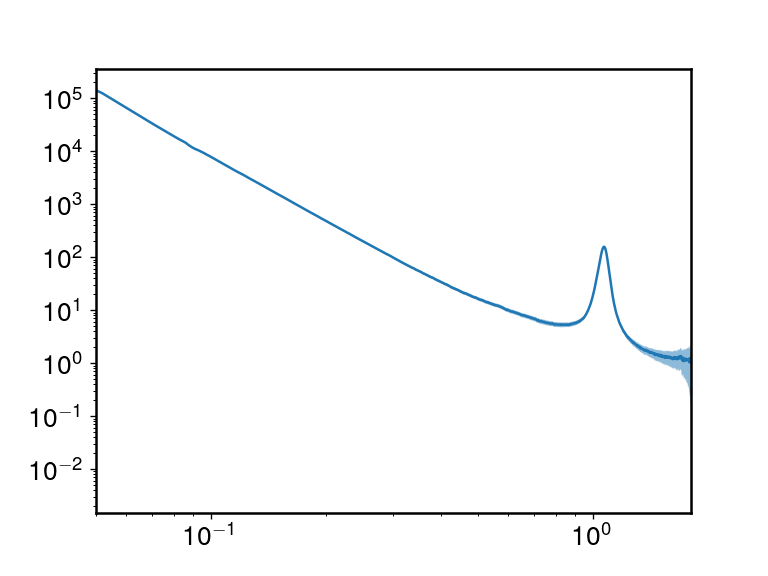

(0.05, 1.81)

In [16]:
scale = 10  # upscaling of poisson error for visibility

fig, ax = plt.subplots()
ax.fill_between(q, I + scale * e, I - scale * e, alpha=0.5)
ax.plot(q, I)
ax.loglog()
ax.set_xlim([0.05, 1.81])

### azimuthal integration 2d

In [17]:
# usage of integrate2d
I2d, q, chi = ai.integrate2d(image, 800, 360, error_model='poisson')

In [18]:
# for additional info uncomment line below
# ai.integrate2d??

<IPython.core.display.Javascript object>


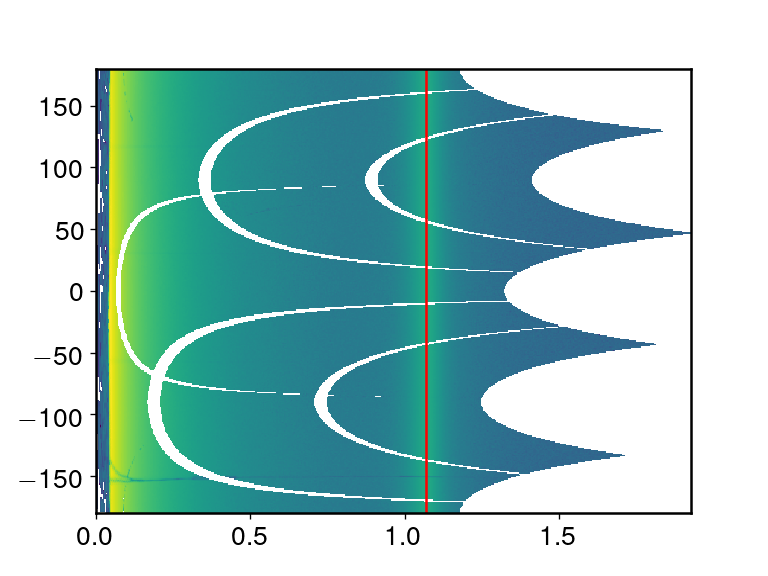

In [19]:
fig, ax = plt.subplots()
extent = [q.min(), q.max(), chi.min(), chi.max()]
ax.imshow(I2d, norm=LogNorm(), extent=extent, aspect='auto')
ax.axvline(x=q_agbh, color='r')